### 1. Project Topic
1. For my final project I've decided to use genetic data from cancer patients with gliomas. Gliomas is the type of brain cancer and for clinicians it's really important to distinguish between two main types of this tumor - LGG (Lower-Grade Glioma) and GBM (Glioblastoma Multiforme). Dataset has information about 20 genes (mutated or not, binary value) and 3 clinical features. And the main point of this project is to find optimal subset of mutation genes and clinical features for the glioma types.
2. This problem can be considered as specific subset of supervised learning where we would need to find best set of predictors that will give us the best results or we can use unsupervised approach here, for example PCA in order to find the best components (with highest eighenvalue) that are describing the most of variance
3. So the main goal would be to try to use unsupervices approach in order to find best subset of parameters that predict cancer type

### 2. Data source
1. I got dataset from the study in International Journal of Molecular Sciences [1] 

And here is a link to download the data - https://archive.ics.uci.edu/static/public/759/glioma+grading+clinical+and+mutation+features+dataset.zip. 

2. Dataset is in csv format and has data about 839 patients (rows) and 23 attributes (columns). Clinical attributes are: Race (Categorical), Gender (Categorical) and Age_at_diagnosis (Continious). Also data has information about mutations in 20 genes, all these variables are Categorical with only 2 values: NOT_MUTATED and MUTATED. All data is within the single table


[1]. Tasci, E., Zhuge, Y., Kaur, H., Camphausen, K., & Krauze, A. V. (2022). Hierarchical Voting-Based Feature Selection and Ensemble Learning Model Scheme for Glioma Grading with Clinical and Molecular Characteristics. International Journal of Molecular Sciences, 23(22), 14155.

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 3. Data cleaning

In [2]:
dataset = pd.read_csv("/Users/alexey/Downloads/glioma+grading+clinical+and+mutation+features+dataset/TCGA_GBM_LGG_Mutations_all.csv")

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Grade              862 non-null    object
 1   Project            862 non-null    object
 2   Case_ID            862 non-null    object
 3   Gender             862 non-null    object
 4   Age_at_diagnosis   862 non-null    object
 5   Primary_Diagnosis  862 non-null    object
 6   Race               862 non-null    object
 7   IDH1               862 non-null    object
 8   TP53               862 non-null    object
 9   ATRX               862 non-null    object
 10  PTEN               862 non-null    object
 11  EGFR               862 non-null    object
 12  CIC                862 non-null    object
 13  MUC16              862 non-null    object
 14  PIK3CA             862 non-null    object
 15  NF1                862 non-null    object
 16  PIK3R1             862 non-null    object
 1

### 3.1 First let's explore how many nas we have in the dataset and then decide what we can do with these values

In [4]:
dataset.isna().any()

Grade                False
Project              False
Case_ID              False
Gender               False
Age_at_diagnosis     False
Primary_Diagnosis    False
Race                 False
IDH1                 False
TP53                 False
ATRX                 False
PTEN                 False
EGFR                 False
CIC                  False
MUC16                False
PIK3CA               False
NF1                  False
PIK3R1               False
FUBP1                False
RB1                  False
NOTCH1               False
BCOR                 False
CSMD3                False
SMARCA4              False
GRIN2A               False
IDH2                 False
FAT4                 False
PDGFRA               False
dtype: bool

#### standard approach doesn't show any missing values, but these values might just be encoded differently; let's print out all unique values for every columns excluding Project and Case_ID, as these columns won't be used in the learning

In [5]:
for column_name in dataset.columns:
    if column_name not in ['Project', 'Case_ID']:
        print(f"{column_name}\t{','.join(dataset[column_name].unique())}")

Grade	LGG,GBM
Gender	Male,Female,--
Age_at_diagnosis	51 years 108 days,38 years 261 days,35 years 62 days,32 years 283 days,31 years 187 days,33 years 78 days,35 years 68 days,44 years 239 days,33 years 350 days,87 years,51 years 328 days,54 years 95 days,52 years 214 days,47 years 123 days,34 years 132 days,40 years 192 days,53 years 352 days,41 years 70 days,43 years 161 days,37 years 159 days,47 years 173 days,31 years 8 days,25 years 191 days,66 years 305 days,56 years 250 days,35 years 362 days,51 years 363 days,37 years 32 days,54 years 183 days,32 years 76 days,65 years 28 days,43 years 131 days,51 years 59 days,43 years 221 days,25 years 214 days,45 years 24 days,50 years 153 days,27 years 166 days,53 years 252 days,46 years 144 days,24 years 239 days,--,34 years 70 days,29 years 198 days,45 years 124 days,62 years 90 days,46 years 224 days,36 years 247 days,62 years 202 days,70 years 159 days,53 years 41 days,48 years 124 days,40 years 69 days,40 years 7 days,20 years 359 days

#### from the cell above I can see that:
1. missing values are encoded as '--' and as 'not reported'.
2. Age is in string format, so we would need to convert it to some continious form. I would suggest to convert years to days and add these value to the remaining number of days. I won't take into accout leap years as I woulnd't expect this precision to add any value to our model
3. Other categorical variables should be converted to 0s or 1s

so first let's cound how many rows with missing values we have. For this I will need to explore just three columns: Gender, Age_at_diagnosis and Race. I don't need to explore Primary_Diagnosis column as Grade will be used instead for classification

In [6]:
# Find indices of missing values for Gender column
gender_missing_indices = dataset.index[dataset.Gender.isin(['--', 'not reported'])].tolist()

In [7]:
# Find indices of missing values for Age_at_diagnosis column
age_missing_indices = dataset.index[dataset.Age_at_diagnosis.isin(['--', 'not reported'])].tolist()

In [8]:
# Find indices of missing values for Race column
race_missing_indices = dataset.index[dataset.Race.isin(['--', 'not reported'])].tolist()

In [9]:
# Merge all indices into one list
missing_values_indices = list()
missing_values_indices.extend(gender_missing_indices)
missing_values_indices.extend(age_missing_indices)
missing_values_indices.extend(race_missing_indices)

In [10]:
# Use set to remove non-unique indices
print(f"Number of missing values: {len(set(missing_values_indices))}")
print(f"Missing values indices: {set(missing_values_indices)}")

Number of missing values: 23
Missing values indices: {256, 268, 396, 525, 794, 671, 163, 41, 437, 706, 71, 455, 583, 846, 208, 341, 608, 231, 490, 747, 622, 623, 504}


#### As we can see there are only 23 rows with missing values so I think it will be easier to just remove these rows as it won't affect anyhow our future learning model. Also let's remove 'Primary_Diagnosis', 'Project' and 'Case_ID' columns as we won't use them in the analysis

In [11]:
# let's remove 'Primary_Diagnosis', 'Project' and 'Case_ID' columns from the dataset
dataset = dataset.drop(['Primary_Diagnosis', 'Project', 'Case_ID'], axis=1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Grade             862 non-null    object
 1   Gender            862 non-null    object
 2   Age_at_diagnosis  862 non-null    object
 3   Race              862 non-null    object
 4   IDH1              862 non-null    object
 5   TP53              862 non-null    object
 6   ATRX              862 non-null    object
 7   PTEN              862 non-null    object
 8   EGFR              862 non-null    object
 9   CIC               862 non-null    object
 10  MUC16             862 non-null    object
 11  PIK3CA            862 non-null    object
 12  NF1               862 non-null    object
 13  PIK3R1            862 non-null    object
 14  FUBP1             862 non-null    object
 15  RB1               862 non-null    object
 16  NOTCH1            862 non-null    object
 17  BCOR            

In [12]:
# let's remove rows with missing values
dataset = dataset.drop(set(missing_values_indices), axis=0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 839 entries, 0 to 861
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Grade             839 non-null    object
 1   Gender            839 non-null    object
 2   Age_at_diagnosis  839 non-null    object
 3   Race              839 non-null    object
 4   IDH1              839 non-null    object
 5   TP53              839 non-null    object
 6   ATRX              839 non-null    object
 7   PTEN              839 non-null    object
 8   EGFR              839 non-null    object
 9   CIC               839 non-null    object
 10  MUC16             839 non-null    object
 11  PIK3CA            839 non-null    object
 12  NF1               839 non-null    object
 13  PIK3R1            839 non-null    object
 14  FUBP1             839 non-null    object
 15  RB1               839 non-null    object
 16  NOTCH1            839 non-null    object
 17  BCOR            

In [13]:
# Convert years to days
for row in dataset.iterrows():
    numbers = re.findall(r'\d+', row[1]['Age_at_diagnosis'])
    age = 0
    years_to_day = int(numbers[0]) * 365
    if len(numbers) > 1:
        age = years_to_day + int(numbers[1])
    else:
        age = years_to_day
    row[1]['Age_at_diagnosis'] = years_to_day

In [14]:
# Convert Gender to number, Male = 0, Female = 1
for row in dataset.iterrows():
    if row[1]['Gender'] == 'Male':
        row[1]['Gender'] = 0
    else:
        row[1]['Gender'] = 1

In [15]:
# Convert Grade to number, LGG = 0, GBM = 1
for row in dataset.iterrows():
    if row[1]['Grade'] == 'LGG':
        row[1]['Grade'] = 0
    else:
        row[1]['Grade'] = 1

In [16]:
# Convert Race to humber, white = 0, asian = 1, black or african american = 2, american indian or alaska native = 3
for row in dataset.iterrows():
    if row[1]['Race'] == 'white':
        row[1]['Race'] = 0
    elif row[1]['Race'] == 'asian':
        row[1]['Race'] = 1
    elif row[1]['Race'] == 'black or african american':
        row[1]['Race'] = 2
    else:
        row[1]['Race'] = 3

In [17]:
# Convert genes mutation status to number, MUTATED = 1, NOT_MUTATED = 0
gene_names = [gene_name for gene_name in dataset.columns if gene_name not in ['Grade', 'Gender', 'Age_at_diagnosis', 'Race']]
for row in dataset.iterrows():
    for gene_name in gene_names:
        if row[1][gene_name] == 'NOT_MUTATED':
            row[1][gene_name] = 0
        else:
            row[1][gene_name] = 1

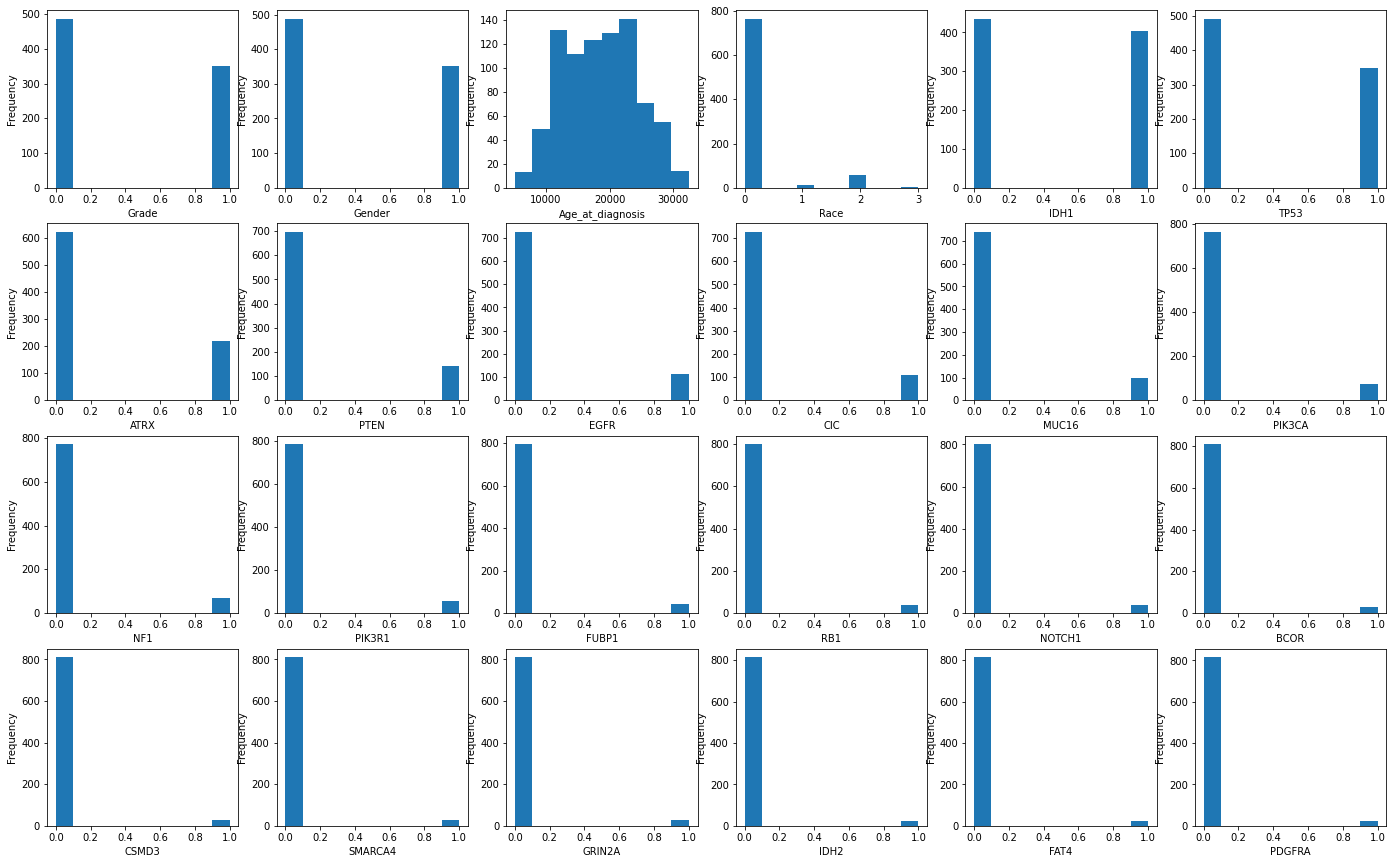

In [18]:
# let's plot histogram of existin values just to check that cleaning was OK
fig = plt.figure(figsize=(24, 15))
i = 0
for column in dataset:
    sub = fig.add_subplot(4, 6, i+1)
    sub.set_xlabel(column)
    dataset[column].plot(kind='hist')
    i += 1

### 3.2 Cleaning stage conclusion:
1. We've removed all missing values
2. We've converted Age to the number of days
3. We've convert all other categorical variables to 0s, 1s, etc...

As I can see from the plot above, Grade, Gender and IDH1 variables looks balanced. Age column more or less similar to normal distribution as it should be and other variables, including Race and most of the genes are quite unbalanced (there are more values of one type than another)

### 4. Exploratory Data Analysis

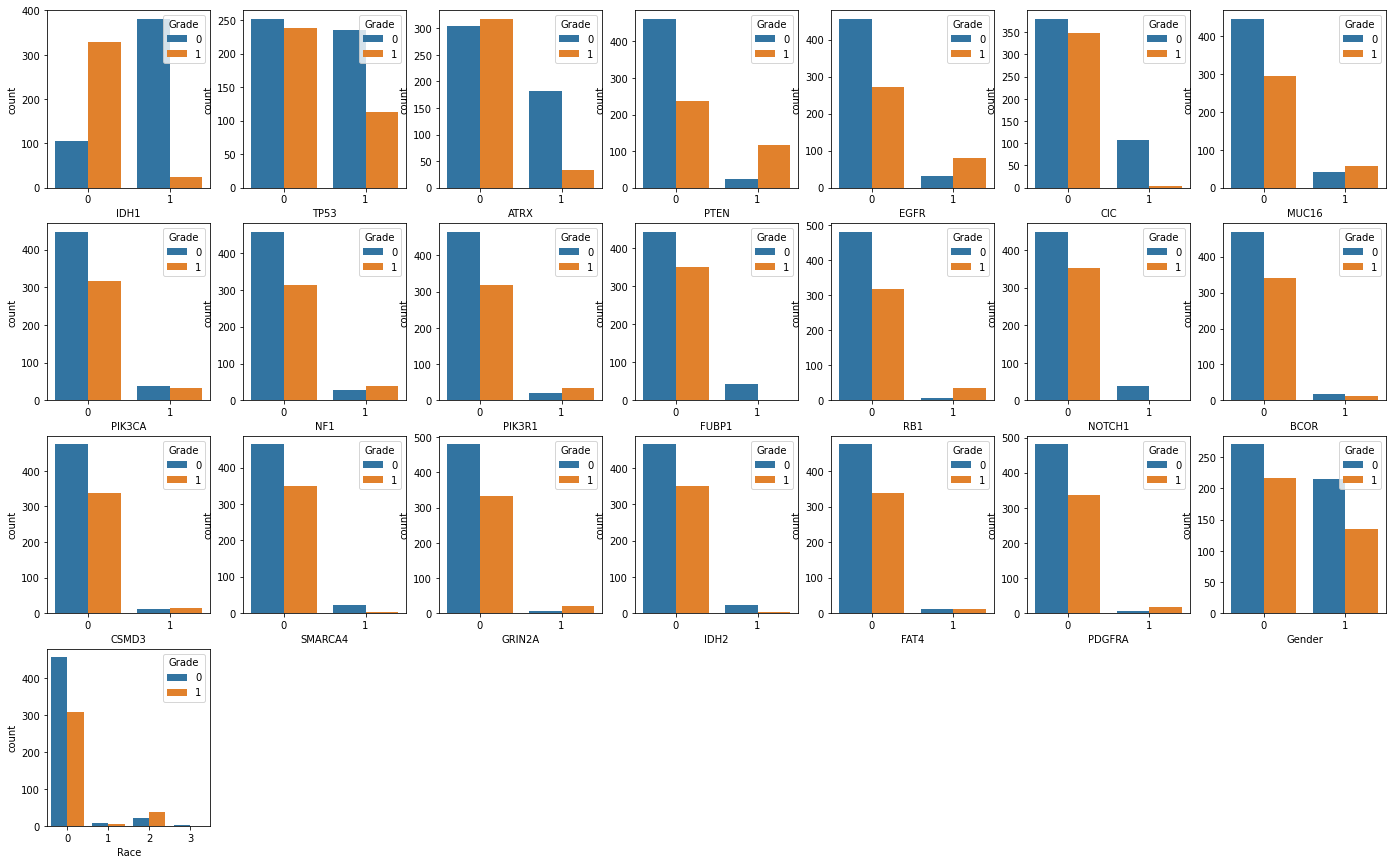

In [19]:
# I've already built histogram of features above and now it would be great to check feature vs target distribution
list_of_columns = gene_names + ['Gender', 'Race']
fig = plt.figure(figsize=(24, 15))

for i in range(len(list_of_columns)):
    column = list_of_columns[i]
    sub = fig.add_subplot(4, 7, i+1)
    chart = sns.countplot(data=dataset, x=column, hue='Grade')

<Axes: xlabel='Grade', ylabel='Age_at_diagnosis'>

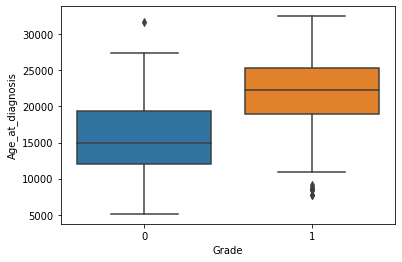

In [20]:
# And finally I would like to build similar plot but for Age_at_diagnosis column
sns.boxplot(x='Grade', y='Age_at_diagnosis', data=dataset)

### 4.1 EDA summary:

1. Many genes represent unbalanced features - it mean that probably they won't give any advantage for a future model
2. For other variables it's possible to see that Grade target is correlated with state of the predictor, it means these feature will be useful for future model
3. Looks like Age_at_diagnosis in generate is linked with GBM

### 5. Models

there are many usupervised algorithms that we can use here but I would suggest to start with PCA in order to find the best components from the dataset [1]

In [78]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
# remove Grade from dataset
data = dataset.drop(['Grade'], axis=1)
# and save it to y varibale
labels = dataset['Grade']


In [63]:
X_reduced = PCA(n_components=2)
X_reduced.fit_transform(data)

array([[ 2.03164470e+02,  1.42837799e-01],
       [-4.54183553e+03,  4.42465398e-01],
       [-5.63683558e+03, -6.94774840e-01],
       ...,
       [ 9.69316448e+03, -6.55441796e-01],
       [ 4.58316449e+03, -3.74670840e-01],
       [ 9.32816450e+03,  7.70669453e-01]])

In [66]:
tmp = pd.DataFrame(X_reduced.components_, columns=data.columns, index = ['PC-1','PC-2'])
print(tmp)

        Gender  Age_at_diagnosis      Race      IDH1      TP53      ATRX  \
PC-1 -0.000001          1.000000  0.000004 -0.000050 -0.000027 -0.000032   
PC-2 -0.079903         -0.000057  0.417245 -0.393159 -0.619215 -0.466266   

          PTEN      EGFR       CIC     MUC16  ...     FUBP1       RB1  \
PC-1  0.000017  0.000013 -0.000007  0.000005  ... -0.000002  0.000004   
PC-2  0.128173  0.152162  0.113785 -0.004185  ...  0.032832 -0.006332   

        NOTCH1          BCOR         CSMD3   SMARCA4        GRIN2A      IDH2  \
PC-1 -0.000002  4.786217e-07  1.195647e-07 -0.000002  8.214369e-07 -0.000004   
PC-2 -0.001187 -1.605723e-02 -1.037730e-02 -0.025727  1.754444e-02  0.050358   

          FAT4    PDGFRA  
PC-1  0.000001  0.000002  
PC-2 -0.004877 -0.001755  

[2 rows x 23 columns]


In [67]:
tmp.max(axis=1)

PC-1    1.000000
PC-2    0.417245
dtype: float64

In [68]:
tmp.min(axis=1)

PC-1   -0.000050
PC-2   -0.619215
dtype: float64

<Axes: >

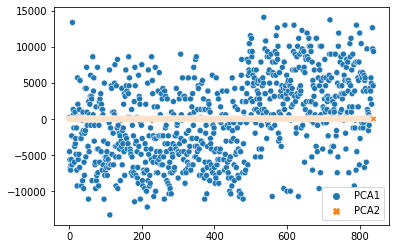

In [70]:
pca = X_reduced.fit_transform(data)
df = pd.DataFrame(data={'PCA1': pca[:, 0], 'PCA2': pca[:, 1]})
sns.scatterplot(df)

In [81]:
# let's check explained variance
X_reduced.explained_variance_ratio_

array([9.99999937e-01, 1.03286230e-08])

as we can see, PCA-1 explains most of the variablitiy in the data

### Let's try to change some hyperparameters and see if we can get better picture

<Axes: >

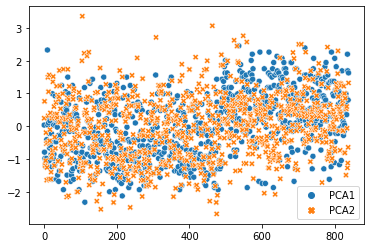

In [73]:
X_reduced = PCA(n_components=2, whiten=True)
X_reduced.fit_transform(data)

pca = X_reduced.fit_transform(data)
df = pd.DataFrame(data={'PCA1': pca[:, 0], 'PCA2': pca[:, 1]})
sns.scatterplot(df)

<Axes: >

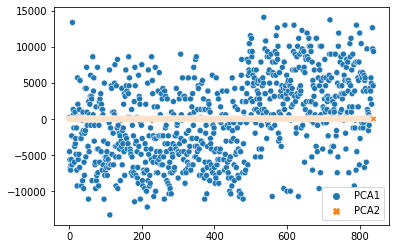

In [75]:
X_reduced = PCA(n_components=2, svd_solver='full')
X_reduced.fit_transform(data)

pca = X_reduced.fit_transform(data)
df = pd.DataFrame(data={'PCA1': pca[:, 0], 'PCA2': pca[:, 1]})
sns.scatterplot(df)

<Axes: >

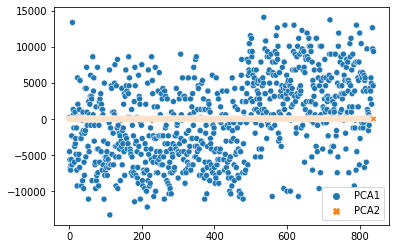

In [77]:
X_reduced = PCA(n_components=2, svd_solver='arpack')
X_reduced.fit_transform(data)

pca = X_reduced.fit_transform(data)
df = pd.DataFrame(data={'PCA1': pca[:, 0], 'PCA2': pca[:, 1]})
sns.scatterplot(df)

### I don't see any substantial improvement so now we can try to compare our results with supervised approach

In [79]:
# split dataset into train and test with 70% to 30% ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_train_transformed = y_train.astype('int')
y_test_transformed = y_test.astype('int')

pipeline = list()
pipeline.append(LogisticRegression(solver='liblinear'))
pipeline.append(GaussianNB())
pipeline.append(SVC())

pipeline.append(DecisionTreeClassifier())
pipeline.append(RandomForestClassifier())
pipeline.append(GradientBoostingClassifier())

accuracy_list = list()
auc_list = list()
cm_list = list()
for model in pipeline:
    print(model)
    model.fit(X_train, y_train_transformed)
    y_pred = model.predict(X_test)
    accuracy_list.append(metrics.accuracy_score(y_test_transformed, y_pred))
    fpr, tpr, _tresholds = metrics.roc_curve(y_test_transformed, y_pred)
    auc_list.append(round(metrics.auc(fpr, tpr), 2))
    cm_list.append(confusion_matrix(y_test_transformed, y_pred))
    
models = ['LogisticRegression', 'GaussianNB', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']

results = pd.DataFrame({'Model': models, 'Accuracy': accuracy_list, 'AUC': auc_list})
results

LogisticRegression(solver='liblinear')
GaussianNB()
SVC()
DecisionTreeClassifier()
RandomForestClassifier()
GradientBoostingClassifier()


,Model,Accuracy,AUC
0,LogisticRegression,0.853175,0.86
1,GaussianNB,0.849206,0.86
2,SVC,0.706349,0.69
3,DecisionTreeClassifier,0.757937,0.75
4,RandomForestClassifier,0.817460,0.81
5,GradientBoostingClassifier,0.857143,0.86


In [80]:
# To explore logistic regression in more details I would use statsmodel library instead
import statsmodels.api as sm


tmp = {'Age_at_diagnosis': list(X_train['Age_at_diagnosis']),
                   'Gender': list(X_train['Gender']),
                   'Race': list(X_train['Race']),
                   'grade': list(y_train)}



for gene_name in gene_names:
    tmp[gene_name] = list(X_train[gene_name])
    
df = pd.DataFrame(tmp)


#define response variable
y = df['grade']

#define predictor variables
x = df[['Age_at_diagnosis', 'Gender', 'Race'] + gene_names]

#add constant to predictor variables
x = sm.add_constant(x)

#fit regression model
model = sm.OLS(y, x).fit()

#view summary of model fit
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     39.68
Date:                Mon, 21 Aug 2023   Prob (F-statistic):          5.57e-102
Time:                        13:15:49   Log-Likelihood:                -136.99
No. Observations:                 587   AIC:                             322.0
Df Residuals:                     563   BIC:                             427.0
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4923      0.074  

These results are pretty much consistent with what logistic regression tells us, on top of results described above logistic regression also reports that other genes might be linked with grade of the cancer, for example IDH1 and PTEN

### 6. Discussion and Conclusion

As we can see from the PCA results, first component actually describes almost all available variation and this component corresponds to the Age_at_diagnosis

**GitHub Repo for this project can be found here:**

https://github.com/also9275/dtsa_5510_final_project

### 7. References

[1] https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html#sphx-glr-auto-examples-datasets-plot-iris-dataset-py